# Analysis of the Stackoverflow Survey of 2018

In this notebook, some analysis on the stackoverflow survey of 2018 will be done.

The analysis is done by following the steps in the table of contents. 

## Table of Contents

I.  [Which questions should be answered?](#Exploratory-Data-Analysis)<br>
II. [Clean the data](#Clean)<br>
III. [Modelling and Analysis for each question](#Modelling)<br>

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import seaborn as sns

In [103]:
df = pd.read_csv('../data/survey_results_public.csv')
df_schema = pd.read_csv('../data/survey_results_schema.csv')

# Show df to get an idea of the data
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


In [105]:
assert df.shape[1] == df_schema.shape[0]
print('The survey contained {} questions. In total, there are {} survey responses.'.format(df.shape[1], df.shape[0]))

The survey contained 154 questions. In total, there are 19102 survey responses.


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Which questions should be answered?</a>

The schema and the data are used to find interessting questions which should be answered in the following analysis.

In [106]:
df_schema.head(n=10)

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."
5,EmploymentStatus,Which of the following best describes your cur...
6,FormalEducation,Which of the following best describes the high...
7,MajorUndergrad,Which of the following best describes your mai...
8,HomeRemote,How often do you work from home or remotely?
9,CompanySize,"In terms of the number of employees, how large..."


**Questions which will be answered in the following parts:**

|#| Question | Additional Information | Helpful columns | Target column |
| ---| :--- | :---| :---| :---|
|1| Does the company influence the happiness/satisfaction of the users?  | only for employed users of a company (EmploymentStatus) | EmploymentStatus, CompanySize, CompanyType, InfluenceInternet, InfluenceWorkstation, InfluenceHardware, InfluenceServers, InfluenceTechStack, InfluenceDeptTech, InfluenceVizTools, InfluenceDatabase, InfluenceCloud, InfluenceConsultants, InfluenceRecruitment, InfluenceCommunication | CareerSatisfaction, JobSatisfaction  |
|2| Exists a correlation between "Overpaid" and "Salary", depending on the experience?  | - | YearsProgram, Overpaid, Salary | *TODO: Maybe use one to predict the other?*|
|3| Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?| - | HaveWorkedLanguage, OtherPeoplesCode, EnjoyDebugging | *TODO: Maybe use one to predict the other?*|
|4|How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?|-|HaveWorkedLanguage |TabsSpaces|

The questions have been found by looking at the df_schema in detail to find interesting questions.

### <a class="anchor" id="Clean">Part II: Clean the data</a>

In [Part |](#Exploratory-Data-Analysis) the needed columns are defined. In the following, the data is preperaded for each question. Only the needed columns are modified and cleaned.

The column *HaveWorkedLanguage* is split into separated columns, one for each programming language. This information is needed for question 3 and 4, so it is done once at the beginning on the original data.


In [107]:
# HAVE WORKED LANGUAGE - Extract available values
# convert all 'HaveWorkedLanguage' entries into lists: df_q3.HaveWorkedLanguage.str.split(';')
df['HaveWorkedLanguageList'] = df.HaveWorkedLanguage.str.split(';')
#flatten all lists to one
prog_languages = set()
for entry in df.HaveWorkedLanguageList:
    if isinstance(entry, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        [prog_languages.add(elem.strip()) for elem in entry]


In [108]:
# convert available programming languages in columns
print(df.columns)
df[list(prog_languages)] = pd.DataFrame(data = np.zeros((df.shape[0],len(prog_languages))), columns = list(prog_languages))
print(df.columns)

Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'Gender', 'HighestEducationParents', 'Race', 'SurveyLong',
       'QuestionsInteresting', 'QuestionsConfusing', 'InterestedAnswers',
       'Salary', 'ExpectedSalary', 'HaveWorkedLanguageList'],
      dtype='object', length=155)
Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'Ruby', 'Visual Basic 6', 'TypeScript', 'VB.NET', 'Scala', 'Python',
       'Common Lisp', 'C', 'Hack', 'Objective-C'],
      dtype='object', length=190)


In [109]:
# Convert HaveWorkedList into binary values for the different programming languages
for idx, prog_lang_list in df.HaveWorkedLanguageList.iteritems():
    if isinstance(prog_lang_list, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        for entry in prog_lang_list:
            entry = entry.strip()
            df.loc[df.index[idx], entry] = 1

In [110]:
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,Ruby,Visual Basic 6,TypeScript,VB.NET,Scala,Python,Common Lisp,C,Hack,Objective-C
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
# Pick the needed columns for each question
df_q1 = df[['EmploymentStatus', 'CompanySize', 'CompanyType', 'InfluenceInternet', 'InfluenceWorkstation', 'InfluenceHardware', 
        'InfluenceServers', 'InfluenceTechStack', 'InfluenceDeptTech', 'InfluenceVizTools', 
        'InfluenceDatabase', 'InfluenceCloud', 'InfluenceConsultants', 'InfluenceRecruitment', 
        'InfluenceCommunication', 'CareerSatisfaction', 'JobSatisfaction']]
df_q2 = df[['YearsProgram', 'Overpaid', 'Salary']]
df_q3 = df[list(prog_languages)+['OtherPeoplesCode', 'EnjoyDebugging']]
df_q4 = df[['Python', 'TabsSpaces']]

#### Cleaning for question 1: Does the company influence the happiness/satisfaction of the users?

In [330]:
df_q1.head()

,EmploymentStatus,CompanySize,CompanyType,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,CareerSatisfaction,JobSatisfaction
0,"Not employed, and not looking for work",NaN,NaN,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Employed part-time,20 to 99 employees,"Privately-held limited company, not in startup...",Satisfied,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,NaN,NaN
2,Employed full-time,"10,000 or more employees",Publicly-traded corporation,Very satisfied,A lot of influence,Some influence,Some influence,Some influence,A lot of influence,Some influence,Some influence,Some influence,Some influence,Some influence,Some influence,8.0,9.0
3,Employed full-time,"10,000 or more employees",Non-profit/non-governmental organization or pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0
4,Employed full-time,10 to 19 employees,"Privately-held limited company, not in startup...",Satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0


In [331]:
# EMPLOYMENT STATUS - Question 1 is only relevant for people who work in a company
print('Answer possibilities for EmploymentStatus: ',df_q1.EmploymentStatus.unique())
df_q1 = df_q1[df_q1.EmploymentStatus.isin(['Employed full-time', 'Employed part-time'])]
df_q1 = df_q1.drop(labels = ['EmploymentStatus'],axis = 1)
print('The number of survey responsed reduced from {} to {}.'.format(df.shape[0], df_q1.shape[0]))

Answer possibilities for EmploymentStatus:  ['Not employed, and not looking for work' 'Employed part-time'
 'Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Not employed, but looking for work' 'I prefer not to say' 'Retired']
The number of survey responsed reduced from 19102 to 14823.


In [332]:
# COMPANY SIZE
print('Answer possibilities for CompanySize: ',df_q1.CompanySize.unique())
# remove entries which do not provide additional information
df_q1.CompanySize = df_q1.CompanySize.replace(["I don't know", "I prefer not to answer"], np.NaN)
df_q1 = df_q1.dropna(axis = 0, subset=['CompanySize'])
#print(df_q1.shape)
#df_q1 = pd.concat([df_q1, pd.get_dummies(df_q1.CompanySize, prefix='CompanySize')], ignore_index = True)
tmp = pd.get_dummies(df_q1.CompanySize, prefix='CompanySize')
#print(tmp.shape)
df_q1[tmp.columns] = tmp
#print(df_q1.shape)
df_q1 = df_q1.drop(labels=['CompanySize'], axis = 1)
#print(df_q1.columns)

Answer possibilities for CompanySize:  ['20 to 99 employees' '10,000 or more employees' '10 to 19 employees'
 'Fewer than 10 employees' '5,000 to 9,999 employees'
 '100 to 499 employees' '1,000 to 4,999 employees' '500 to 999 employees'
 "I don't know" nan 'I prefer not to answer']


In [333]:
# COMPANY TYPE
print('Answer possibilities for CompanyTypeSize: ',df_q1.CompanyType.unique())
# remove entries which do not provide additional information
df_q1.CompanyType = df_q1.CompanyType.replace(["I don't know", "I prefer not to answer"], np.NaN)
df_q1 = df_q1.dropna(axis = 0, subset=['CompanyType'])
#print(df_q1.shape)
# df_q1 = pd.concat([df_q1, pd.get_dummies(df_q1.CompanyType, prefix='CompanyType')])
tmp = pd.get_dummies(df_q1.CompanyType, prefix='CompanyType')
#print(tmp.shape)
df_q1[tmp.columns] = tmp
#print(df_q1.shape)
df_q1 = df_q1.drop(labels=['CompanyType'], axis = 1)
#print(df_q1.columns)

Answer possibilities for CompanyTypeSize:  ['Privately-held limited company, not in startup mode'
 'Publicly-traded corporation'
 'Non-profit/non-governmental organization or private school/university'
 'Government agency or public school/university' 'Pre-series A startup'
 'Venture-funded startup' "I don't know"
 'Sole proprietorship or partnership, not in startup mode'
 'I prefer not to answer' 'State-owned company' 'Something else' nan]


In [334]:
# INFLUENCE
influence_columns = ['InfluenceInternet', 'InfluenceWorkstation', 'InfluenceHardware', 
        'InfluenceServers', 'InfluenceTechStack', 'InfluenceDeptTech', 'InfluenceVizTools', 
        'InfluenceDatabase', 'InfluenceCloud', 'InfluenceConsultants', 'InfluenceRecruitment', 
        'InfluenceCommunication']
for column in influence_columns:
    df_q1 = df_q1.dropna(axis = 0, subset=[column])
    tmp = pd.get_dummies(df_q1[column], prefix=column)
    #print(tmp.shape)
    df_q1[tmp.columns] = tmp
    #print(df_q1.shape)
    df_q1 = df_q1.drop(labels=[column], axis = 1)

    
    #df_q1 = df_q1.dropna(axis = 0, subset=[column])
    #df_q1 = pd.concat([df_q1, pd.get_dummies(df_q1[column], prefix=column)])
    #df_q1 = df_q1.drop(labels=[column], axis = 1)
#unique_values


In [335]:
# JOB SATISFACTION
mean = int(df_q1.JobSatisfaction.mean())
# as the satisfaction is on a scale, the mean has been converted to an integer as well
df_q1.JobSatisfaction = df_q1.JobSatisfaction.fillna(mean)

In [336]:
# CAREER SATISFACTION
mean = int(df_q1.CareerSatisfaction.mean())
# as the satisfaction is on a scale, the mean has been converted to an integer as well
df_q1.CareerSatisfaction = df_q1.CareerSatisfaction.fillna(mean)

#### Cleaning for question 2: Exists a correlation between "Overpaid" and "Salary"?

In [200]:
# Calculation makes only sense if both values are available
df_q2 = df_q2.dropna(subset = ['Overpaid', 'Salary'])
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q2.shape[0]))

The number of survey responsdents reduced from 19102 to 4995.


In [151]:
# YEARS PROGRAM
print('Answer possibilities for YearsProgram: ',df_q2.YearsProgram.unique())
# remove entries which do not provide additional information
df_q2 = df_q2.dropna(axis = 0, subset=['YearsProgram'])
print(df_q2.shape)
tmp = pd.get_dummies(df_q2.YearsProgram, prefix='YearsProgram')
print(tmp.shape)
df_q2[tmp.columns] = tmp
print(df_q2.shape)
df_q2 = df_q2.drop(labels=['YearsProgram'], axis = 1)

Answer possibilities for YearsProgram:  ['20 or more years' '2 to 3 years' '10 to 11 years' '7 to 8 years'
 '4 to 5 years' '8 to 9 years' '11 to 12 years' '3 to 4 years'
 '5 to 6 years' '9 to 10 years' '17 to 18 years' '14 to 15 years'
 '1 to 2 years' '16 to 17 years' '12 to 13 years' '18 to 19 years'
 '6 to 7 years' '15 to 16 years' '13 to 14 years' '19 to 20 years'
 'Less than a year' nan]
(4989, 3)
(4989, 21)
(4989, 24)


In [201]:
# Convert Overpaid column to numeric target column
label_encoder = LabelEncoder()
target_column = label_encoder.fit_transform(df_q2.Overpaid)
df_q2['target'] = target_column
#df_q2 = df_q2.drop(labels=['Overpaid'], axis = 1)
print(df_q2.head())

        YearsProgram                        Overpaid    Salary  target
2   20 or more years  Neither underpaid nor overpaid  113750.0       2
14  20 or more years              Somewhat underpaid  100000.0       4
17  20 or more years  Neither underpaid nor overpaid  130000.0       2
18      2 to 3 years               Somewhat overpaid   82500.0       3
22    10 to 11 years  Neither underpaid nor overpaid  100764.0       2


In [121]:
## OVERPAID
#print('Answer possibilities for Overpaid: ',df_q2.Overpaid.unique())
## remove entries which do not provide additional information
#df_q2 = df_q2.dropna(axis = 0, subset=['Overpaid'])
#print(df_q2.shape)
#tmp = pd.get_dummies(df_q2.Overpaid, prefix='Overpaid')
#print(tmp.shape)
#df_q2[tmp.columns] = tmp
#print(df_q2.shape)
#df_q2 = df_q2.drop(labels=['Overpaid'], axis = 1)

Answer possibilities for Overpaid:  ['Neither underpaid nor overpaid' 'Somewhat underpaid' 'Somewhat overpaid'
 'Greatly underpaid' 'Greatly overpaid']
(4989, 23)
(4989, 5)
(4989, 28)


#### Cleaning for question 3: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?

In [280]:
# Calculation makes only sense if both values 'OtherPeoplesCode' and 'EnjoyDebugging' are available
df_q3 = df_q3.dropna(subset = ['EnjoyDebugging', 'OtherPeoplesCode'], how = 'any')
#df_q3 = df_q3.reset_index(drop = True)
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q3.shape[0]))

The number of survey responsdents reduced from 19102 to 11148.


In [293]:
# OTHER PEOPLE CODE
tmp = pd.get_dummies(df_q3.OtherPeoplesCode, prefix='OtherPeoplesCode', prefix_sep='_')
#print(tmp.shape)
df_q3[tmp.columns] = tmp
#print(df_q1.shape)
df_q3 = df_q3.drop(labels=['OtherPeoplesCode'], axis = 1)

In [294]:
# ENJOY DEBUGGING
tmp = pd.get_dummies(df_q3.EnjoyDebugging, prefix='EnjoyDebugging', prefix_sep='_')
#print(tmp.shape)
df_q3[tmp.columns] = tmp
#print(df_q1.shape)
df_q3 = df_q3.drop(labels=['EnjoyDebugging'], axis = 1)

In [295]:
df_q3.head()

,R,Smalltalk,Matlab,VBA,PHP,Clojure,JavaScript,Rust,Dart,Haskell,...,OtherPeoplesCode_Agree,OtherPeoplesCode_Disagree,OtherPeoplesCode_Somewhat agree,OtherPeoplesCode_Strongly agree,OtherPeoplesCode_Strongly disagree,EnjoyDebugging_Agree,EnjoyDebugging_Disagree,EnjoyDebugging_Somewhat agree,EnjoyDebugging_Strongly agree,EnjoyDebugging_Strongly disagree
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0,0,1,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


#### Cleaning for question 4: How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?


In [126]:
# Extract only the people who programm in Python
print(df_q4.head())
df_q4 = df_q4[df_q4.Python == 1]
print(df_q4.head())

   Python TabsSpaces
0     0.0       Tabs
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
4     0.0        NaN
   Python TabsSpaces
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
6     1.0     Spaces
7     1.0     Spaces


In [127]:
# TABS SPACES
tmp = pd.get_dummies(df_q4.TabsSpaces, prefix='TabsSpaces', prefix_sep='_')
#print(tmp.shape)
df_q4[tmp.columns] = tmp
#print(df_q1.shape)
df_q4 = df_q4.drop(labels=['TabsSpaces'], axis = 1)

### <a class="anchor" id="Modelling">Part III: Modelling and Analysis for each question</a>
As the data has already be preprocessed, the pipeline only contain the machine learning classifier.

#### Modelling for question 1: Does the company influence the happiness/satisfaction of the users?

In [337]:
df_q1.head()

,CareerSatisfaction,JobSatisfaction,"CompanySize_1,000 to 4,999 employees",CompanySize_10 to 19 employees,"CompanySize_10,000 or more employees",CompanySize_100 to 499 employees,CompanySize_20 to 99 employees,"CompanySize_5,000 to 9,999 employees",CompanySize_500 to 999 employees,CompanySize_Fewer than 10 employees,...,InfluenceRecruitment_A lot of influence,InfluenceRecruitment_I am the final decision maker,InfluenceRecruitment_No influence at all,InfluenceRecruitment_Not much influence,InfluenceRecruitment_Some influence,InfluenceCommunication_A lot of influence,InfluenceCommunication_I am the final decision maker,InfluenceCommunication_No influence at all,InfluenceCommunication_Not much influence,InfluenceCommunication_Some influence
1,7.0,7.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,8.0,9.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,7.0,6.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7,7.0,7.0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
8,6.0,6.0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [338]:
df_q1.columns

Index(['CareerSatisfaction', 'JobSatisfaction',
       'CompanySize_1,000 to 4,999 employees',
       'CompanySize_10 to 19 employees',
       'CompanySize_10,000 or more employees',
       'CompanySize_100 to 499 employees', 'CompanySize_20 to 99 employees',
       'CompanySize_5,000 to 9,999 employees',
       'CompanySize_500 to 999 employees',
       'CompanySize_Fewer than 10 employees',
       'CompanyType_Government agency or public school/university',
       'CompanyType_Non-profit/non-governmental organization or private school/university',
       'CompanyType_Pre-series A startup',
       'CompanyType_Privately-held limited company, not in startup mode',
       'CompanyType_Publicly-traded corporation',
       'CompanyType_Sole proprietorship or partnership, not in startup mode',
       'CompanyType_Something else', 'CompanyType_State-owned company',
       'CompanyType_Venture-funded startup',
       'InfluenceInternet_Not at all satisfied',
       'InfluenceInternet_Not ver

**Prediction of Career Satisfaction**

In [349]:
# Logistic Regression with Gridsearch

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

X = df_q1.drop(labels=['CareerSatisfaction', 'JobSatisfaction'],axis=1)
Y = df_q1.CareerSatisfaction

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

params = {
    'n_estimators': [500], 
    'max_depth': [4], 
    'min_samples_split': [2],
    'learning_rate': [0.01], 
    'loss': ['ls']
}

dt =  GradientBoostingRegressor()
lr_gs = GridSearchCV(dt, params, cv=3, verbose=1).fit(X_train, Y_train)

print("Best Params", lr_gs.best_params_)
print("Best Score", lr_gs.best_score_)

#lr_best = LogisticRegression(plug in best params here)
#lr_best.fit(X_train, y_train)
#lr_best.score(X_test, y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.7s finished


Best Params {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 500}
Best Score 0.035861348260898596


**Prediction of JobSatisfaction**

In [ ]:
TODO

#### Analysis for question 2: Exists a correlation between "Overpaid" and "Salary", depending on the experience?
As the target column *Overpaid* is categorical, a multinomial approach has to be used.

In [202]:
df_q2.head()

,YearsProgram,Overpaid,Salary,target
2,20 or more years,Neither underpaid nor overpaid,113750.0,2
14,20 or more years,Somewhat underpaid,100000.0,4
17,20 or more years,Neither underpaid nor overpaid,130000.0,2
18,2 to 3 years,Somewhat overpaid,82500.0,3
22,10 to 11 years,Neither underpaid nor overpaid,100764.0,2


In [207]:
label_encoder.classes_

'Neither underpaid nor overpaid'

In [243]:
#f =df_q2.groupby(by=['YearsProgram', 'target'])
#df_q2.groupby(['Type'])['Name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
#print(d)

from collections import defaultdict

dict_experience = defaultdict(dict)

#dict_experience = dict.fromkeys(df_q2.YearsProgram.unique(), {})
print(dict_experience)

for key, data in df_q2.groupby(by=['YearsProgram', 'Overpaid']):
    experience = key[0]
    overpaid_target = key[1]
    value = data.YearsProgram.count()
    #print('exp: ', experience)
    #print('overpaid_target: ',overpaid_target)
    #print('value: ', value)
    #print(dict_experience[experience])
    dict_experience[experience][overpaid_target] = value
    #print(dict_experience[experience])
    
print(dict_experience)

defaultdict(<class 'dict'>, {})
defaultdict(<class 'dict'>, {'1 to 2 years': {'Greatly underpaid': 15, 'Neither underpaid nor overpaid': 28, 'Somewhat overpaid': 4, 'Somewhat underpaid': 28}, '10 to 11 years': {'Greatly overpaid': 2, 'Greatly underpaid': 33, 'Neither underpaid nor overpaid': 111, 'Somewhat overpaid': 20, 'Somewhat underpaid': 132}, '11 to 12 years': {'Greatly overpaid': 1, 'Greatly underpaid': 17, 'Neither underpaid nor overpaid': 68, 'Somewhat overpaid': 9, 'Somewhat underpaid': 94}, '12 to 13 years': {'Greatly overpaid': 1, 'Greatly underpaid': 14, 'Neither underpaid nor overpaid': 68, 'Somewhat overpaid': 13, 'Somewhat underpaid': 91}, '13 to 14 years': {'Greatly underpaid': 13, 'Neither underpaid nor overpaid': 66, 'Somewhat overpaid': 14, 'Somewhat underpaid': 59}, '14 to 15 years': {'Greatly overpaid': 3, 'Greatly underpaid': 20, 'Neither underpaid nor overpaid': 95, 'Somewhat overpaid': 13, 'Somewhat underpaid': 122}, '15 to 16 years': {'Greatly overpaid': 1, 'G

In [257]:
key2 = 'Greatly underpaid'
greatly_underpaid = [dict_experience[key1][key2] if key2 in dict_experience[key1].keys() else 0 for key1 in dict_experience.keys()]
key2 = 'Somewhat underpaid'
underpaid = [dict_experience[key1][key2] if key2 in dict_experience[key1].keys() else 0 for key1 in dict_experience.keys()]
key2 = 'Neither underpaid nor overpaid'
neither = [dict_experience[key1][key2] if key2 in dict_experience[key1].keys() else 0 for key1 in dict_experience.keys()]
key2 = 'Somewhat overpaid'
overpaid = [dict_experience[key1][key2] if key2 in dict_experience[key1].keys() else 0 for key1 in dict_experience.keys()]
key2 = 'Greatly overpaid'
greatly_overpaid = [dict_experience[key1][key2] if key2 in dict_experience[key1].keys() else 0 for key1 in dict_experience.keys()]

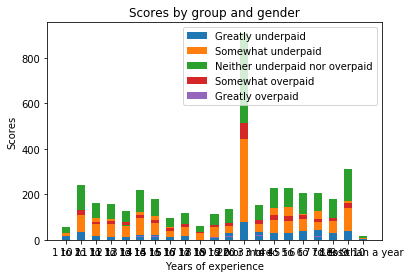

In [276]:
N = len(greatly_overpaid)
ind = np.arange(N)    # the x locations for the groups
width = 0.55       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, greatly_underpaid, width)
p2 = plt.bar(ind, underpaid, width,
             bottom=greatly_underpaid)
p3 = plt.bar(ind, neither, width,
             bottom=underpaid)
p4 = plt.bar(ind, overpaid, width,
             bottom=neither)
p5 = plt.bar(ind, greatly_overpaid, width,
             bottom=overpaid)

plot_xticks = [elem.split(' years')[0] for elem in list(dict_experience.keys())]

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, plot_xticks)#('0-5', '5-10', '10-15', '15+'))
plt.xlabel('Years of experience')
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), 
           ('Greatly underpaid', 'Somewhat underpaid', 'Neither underpaid nor overpaid', 'Somewhat overpaid', 'Greatly overpaid'))

plt.show()

#### Analysis for question 3: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?
As the target column *EnjoyDebugging* is categorical, a multinomial approach has to be used.

In [130]:
df_q3.head()

,R,Smalltalk,Matlab,VBA,PHP,Clojure,JavaScript,Rust,Dart,Haskell,...,OtherPeoplesCode_Agree,OtherPeoplesCode_Disagree,OtherPeoplesCode_Somewhat agree,OtherPeoplesCode_Strongly agree,OtherPeoplesCode_Strongly disagree,EnjoyDebugging_Agree,EnjoyDebugging_Disagree,EnjoyDebugging_Somewhat agree,EnjoyDebugging_Strongly agree,EnjoyDebugging_Strongly disagree
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0,0,1,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


['OtherPeoplesCode_Agree', 'OtherPeoplesCode_Disagree', 'OtherPeoplesCode_Somewhat agree', 'OtherPeoplesCode_Strongly agree', 'OtherPeoplesCode_Strongly disagree', 'EnjoyDebugging_Agree', 'EnjoyDebugging_Disagree', 'EnjoyDebugging_Somewhat agree', 'EnjoyDebugging_Strongly agree', 'EnjoyDebugging_Strongly disagree']


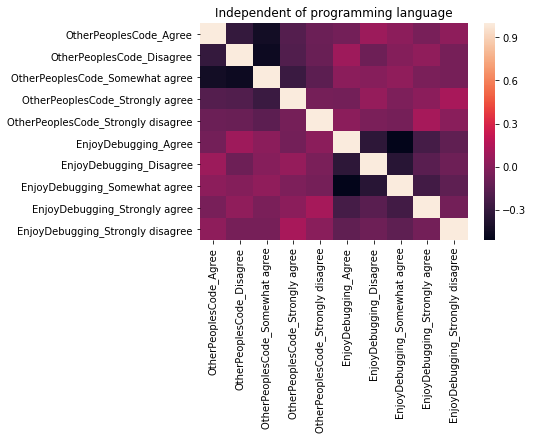

In [307]:
target_columns = [elem for elem in df_q3.columns if elem not in list(prog_languages)]
print(target_columns)
corr_df_q3 = df_q3[target_columns]

corr = corr_df_q3.corr()
plt.title('Independent of programming language')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    

35


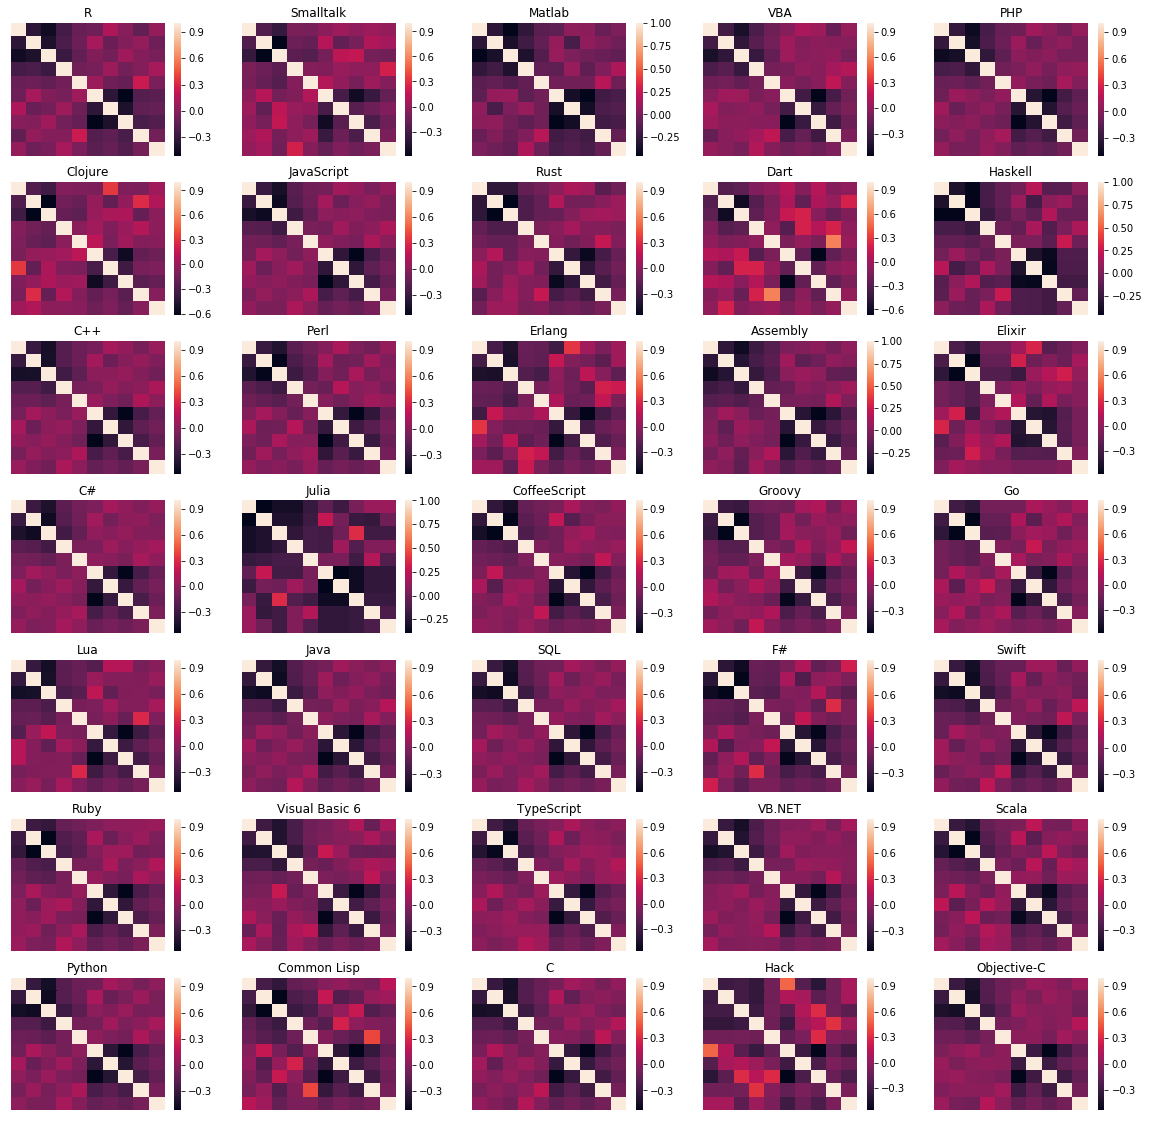

In [326]:
target_columns = [elem for elem in df_q3.columns if elem not in list(prog_languages)]
# Organizing plots
fig, axs = plt.subplots(7,5, figsize=(20, 20), facecolor='w', edgecolor='k')
#axs = axs.ravel()
#print(target_columns)
#

for idx, language in enumerate(prog_languages):
    # Only users who use this language are regarded
    tmp = df_q3[df_q3[language] == 1]
    #print(tmp)
    corr_df_q3 = tmp[target_columns]
    corr = corr_df_q3.corr()
    
    
    plt.subplot(7,5,idx+1) 
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html#plt.subplot:-Simple-Grids-of-Subplots
    plt.title(language)
    sns.heatmap(corr, xticklabels=[], yticklabels=[])


#### Analysis for question 4: How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?

In [131]:
df_q4.head()

,Python,TabsSpaces_Both,TabsSpaces_Spaces,TabsSpaces_Tabs
1,1.0,0,1,0
2,1.0,0,1,0
3,1.0,0,1,0
6,1.0,0,1,0
7,1.0,0,1,0


This question aims at a percentage, not a prediction. Therefore, no attempt to apply a machine learning model was made.

In [132]:
sum_spaces = df_q4.TabsSpaces_Spaces.sum()
sum_tabs = df_q4.TabsSpaces_Tabs.sum()
sum_both = df_q4.TabsSpaces_Both.sum()
print('{} Stackoverflow users who programm in Python use Spaces, '
      'as it is suggested by the PEP8 guidelines. This are {:.2f}% of all python users in this survey.'
      .format(sum_spaces, (sum_spaces/df_q4.shape[0])*100))


print('{} of the survey participants which programm in Python have not '
      'heard about PEP8 yet and use tabs for indentation. Hopefully this number will decrease.'.format(sum_tabs))

print('Only {:.2f}% of the Python programmers write a mixture of tabs and spaces. If they are only programming '
      'Python, this means that they use Python 2, because Python 3 does not allow '
      'a mixing of tabs and spaces anymore.'
      .format((sum_both/df_q4.shape[0])*100))

2119 Stackoverflow users who programm in Python use Spaces, as it is suggested by the PEP8 guidelines. This are 50.46% of all python users in this survey.
1457 of the survey participants which programm in Python have not heard about PEP8 yet and use tabs for indentation. Hopefully this number will decrease.
Only 14.57% of the Python programmers write a mixture of tabs and spaces. If they are only programming Python, this means that they use Python 2, because Python 3 does not allow a mixing of tabs and spaces anymore.
